In [1]:
# Display settings
import warnings
warnings.filterwarnings('ignore')

# My dear old friends
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
from numpy import where
from numpy import mean

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database libraries
import sqlalchemy as db
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, Integer, Table, Column, MetaData

import math
from collections import Counter
from flask import jsonify
import random

# Machine learning libraries
# loading linear algorithms
from sklearn.linear_model import LogisticRegression

# tree based algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# machine learning processing and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle 

In [2]:
# Create SQLite db
restaurants_db = "restaurants.sqlite"
connector = (f"sqlite:///{restaurants_db}")

# Create engine
engine = create_engine(connector)

# Create metadata access to the object
meta_data = db.MetaData(bind=engine)
db.MetaData.reflect(meta_data)

# # Get the tables from the metadata object
# attributes = meta_data.tables["RestaurantAttributes"]
# restaurants = meta_data.tables["Restaurants"]


In [3]:
# Select data into dataframe
# sql_join = r"select RestaurantAttributes.*,stars, latitude, longitude from RestaurantAttributes inner join Restaurants on RestaurantAttributes.business_id = Restaurants.business_id"
sql_join = """
select RestaurantAttributes.BusinessAcceptsCreditCards,
	RestaurantAttributes.GoodForKids,
	RestaurantAttributes.WheelchairAccessible,
	RestaurantAttributes.AlcoholId,
	RestaurantAttributes.BusinessParkingTypeId,
	RestaurantAttributes.RestaurantsTypeId,
	RestaurantAttributes.GoodForMealTypeId,
	Restaurants.stars, 
	Restaurants.latitude, 
	Restaurants.longitude 
from RestaurantAttributes 
inner join Restaurants 
	on RestaurantAttributes.business_id = Restaurants.business_id;
"""

restaurants_df = pd.read_sql(sql_join, engine)

# Hang onto business_id for later, just in case
# business_id_df = restaurants_df["business_id"]
# restaurants_df.pop("business_id")

# # Don't need change_date
# restaurants_df.pop("change_date")

restaurants_df.head()

,BusinessAcceptsCreditCards,GoodForKids,WheelchairAccessible,AlcoholId,BusinessParkingTypeId,RestaurantsTypeId,GoodForMealTypeId,stars,latitude,longitude
0,0,0,1,1,4,0,0,4.5,40.241548,-80.212815
1,0,0,0,1,2,0,0,3.0,43.711399,-79.399339
2,0,0,0,1,0,2,0,3.5,35.047287,-80.990559
3,0,1,0,1,0,0,0,3.0,45.506772,-73.566725
4,0,0,1,1,4,0,0,3.5,40.041003,-75.542497


In [4]:
for col in restaurants_df:
#     print(f"Name: {col} | Values: {restaurants_df[col].unique()}")
    print(f"Value counts for {col}: \n{restaurants_df[col].value_counts()}")

# Most values are "Na" or "No" and only a handful have actual values selected. This portends evil...

Value counts for BusinessAcceptsCreditCards: 
0    13824
1       24
Name: BusinessAcceptsCreditCards, dtype: int64
Value counts for GoodForKids: 
0    10201
1     3647
Name: GoodForKids, dtype: int64
Value counts for WheelchairAccessible: 
0    9175
1    4673
Name: WheelchairAccessible, dtype: int64
Value counts for AlcoholId: 
1    13379
2      354
3       75
4       40
Name: AlcoholId, dtype: int64
Value counts for BusinessParkingTypeId: 
0    8289
4    3496
2    1631
1     203
5     201
3      28
Name: BusinessParkingTypeId, dtype: int64
Value counts for RestaurantsTypeId: 
0    12731
2      434
4      291
5      241
6      122
3       29
Name: RestaurantsTypeId, dtype: int64
Value counts for GoodForMealTypeId: 
0    13599
4      134
3       57
6       25
5       24
1        8
2        1
Name: GoodForMealTypeId, dtype: int64
Value counts for stars: 
3.5    3581
4.0    3194
3.0    2950
2.5    1485
4.5    1363
2.0     678
5.0     333
1.5     209
1.0      55
Name: stars, dtype: int64
V

In [5]:
# drop string cols - they're already encoded in the id cols
string_cols = restaurants_df.select_dtypes(include=["object"]).columns.tolist()
string_cols

restaurants_df.drop(string_cols, axis=1, inplace=True)
restaurants_df.dtypes

BusinessAcceptsCreditCards      int64
GoodForKids                     int64
WheelchairAccessible            int64
AlcoholId                       int64
BusinessParkingTypeId           int64
RestaurantsTypeId               int64
GoodForMealTypeId               int64
stars                         float64
latitude                      float64
longitude                     float64
dtype: object

In [6]:
print(restaurants_df.stars.value_counts())
restaurants_df.stars.describe()

3.5    3581
4.0    3194
3.0    2950
2.5    1485
4.5    1363
2.0     678
5.0     333
1.5     209
1.0      55
Name: stars, dtype: int64


count    13848.000000
mean         3.422516
std          0.748382
min          1.000000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: stars, dtype: float64

3.5    3581
4.0    3194
3.0    2950
2.5    1485
4.5    1363
2.0     678
5.0     333
1.5     209
1.0      55
Name: stars, dtype: int64


<AxesSubplot:ylabel='Density'>

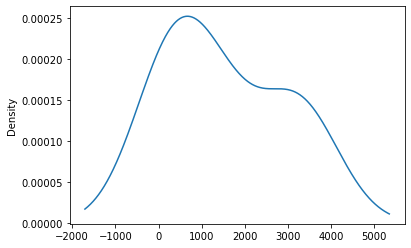

In [7]:
# Visualize the value counts of stars
stars_counts = restaurants_df.stars.value_counts()
print(stars_counts)

stars_counts.plot.density()

4    6775
3    4435
5    1696
2     887
Name: stars, dtype: int64


<AxesSubplot:ylabel='Density'>

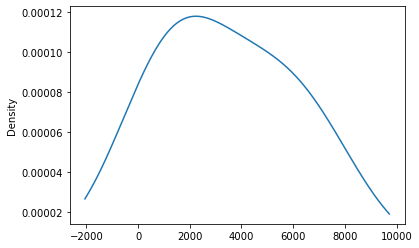

In [8]:
# convert stars to categories
model_df = restaurants_df.copy()

# Rounding didn't help - lets try binary classes
# # Round the target column and convert to integer for processing; being generous and rounding favorably!
# model_df['stars'] = model_df['stars'].apply(np.ceil).astype(int)

# # Drop 1* reviews as there arent enough of them to make a difference
# model_df.drop(model_df.loc[model_df.stars == 1].index, inplace=True)

# rounded_counts = model_df.stars.value_counts()
# print(rounded_counts)

# rounded_counts.plot.density()

# This was a terrible tragedy... switching back to rounding, will drop 2* reviews as well and see what happens
# model_df.loc[model_df["stars"] < 4] = 0
# model_df.loc[model_df["stars"] >= 4] = 1

# model_df.head()

# Round the target column and convert to integer for processing; being generous and rounding favorably!
model_df['stars'] = model_df['stars'].apply(np.ceil).astype(int)

# # Drop 1 and 2* reviews as there arent enough of them to make a difference
# model_df.drop(model_df.loc[model_df.stars <= 2].index, inplace=True)

# Drop 1* reviews as there arent enough of them to make a difference
model_df.drop(model_df.loc[model_df.stars <= 1].index, inplace=True)

rounded_counts = model_df.stars.value_counts()
print(rounded_counts)

rounded_counts.plot.density()


In [9]:
corrs = abs(model_df.corr())["stars"].sort_values(ascending=False)
corrs

# No data point has a direct correlation to the stars

stars                         1.000000
longitude                     0.044939
GoodForMealTypeId             0.039831
BusinessParkingTypeId         0.039066
GoodForKids                   0.035261
latitude                      0.023214
AlcoholId                     0.004512
BusinessAcceptsCreditCards    0.004179
RestaurantsTypeId             0.003319
WheelchairAccessible          0.002193
Name: stars, dtype: float64

In [10]:
model_df.info()

# No nulls, the only string is the business_id; stars is still a float and needs to be categorized

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13793 entries, 0 to 13847
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   BusinessAcceptsCreditCards  13793 non-null  int64  
 1   GoodForKids                 13793 non-null  int64  
 2   WheelchairAccessible        13793 non-null  int64  
 3   AlcoholId                   13793 non-null  int64  
 4   BusinessParkingTypeId       13793 non-null  int64  
 5   RestaurantsTypeId           13793 non-null  int64  
 6   GoodForMealTypeId           13793 non-null  int64  
 7   stars                       13793 non-null  int32  
 8   latitude                    13793 non-null  float64
 9   longitude                   13793 non-null  float64
dtypes: float64(2), int32(1), int64(7)
memory usage: 1.1 MB


In [11]:
target = ["stars"]

columns = model_df.columns.values.tolist()
columns.remove(target[0])

columns

['BusinessAcceptsCreditCards',
 'GoodForKids',
 'WheelchairAccessible',
 'AlcoholId',
 'BusinessParkingTypeId',
 'RestaurantsTypeId',
 'GoodForMealTypeId',
 'latitude',
 'longitude']

In [12]:
model_df.head()

,BusinessAcceptsCreditCards,GoodForKids,WheelchairAccessible,AlcoholId,BusinessParkingTypeId,RestaurantsTypeId,GoodForMealTypeId,stars,latitude,longitude
0,0,0,1,1,4,0,0,5,40.241548,-80.212815
1,0,0,0,1,2,0,0,3,43.711399,-79.399339
2,0,0,0,1,0,2,0,4,35.047287,-80.990559
3,0,1,0,1,0,0,0,3,45.506772,-73.566725
4,0,0,1,1,4,0,0,4,40.041003,-75.542497


In [13]:
correlations = restaurants_df.corr()
correlations

,BusinessAcceptsCreditCards,GoodForKids,WheelchairAccessible,AlcoholId,BusinessParkingTypeId,RestaurantsTypeId,GoodForMealTypeId,stars,latitude,longitude
BusinessAcceptsCreditCards,1.000000,-0.024914,-0.029736,-0.007037,-0.025705,-0.011396,-0.005459,0.007794,0.005995,0.002373
GoodForKids,-0.024914,1.000000,-0.426718,-0.100978,-0.057617,-0.163530,-0.078334,0.039343,0.063823,0.024818
WheelchairAccessible,-0.029736,-0.426718,1.000000,-0.120524,0.356591,-0.195185,-0.093497,0.006751,-0.209693,-0.174730
AlcoholId,-0.007037,-0.100978,-0.120524,1.000000,-0.128112,-0.046188,-0.022125,-0.001139,-0.060173,-0.044214
BusinessParkingTypeId,-0.025705,-0.057617,0.356591,-0.128112,1.000000,-0.152526,0.158990,0.047048,-0.243929,-0.231508
RestaurantsTypeId,-0.011396,-0.163530,-0.195185,-0.046188,-0.152526,1.000000,0.108441,-0.001462,0.084603,0.076282
GoodForMealTypeId,-0.005459,-0.078334,-0.093497,-0.022125,0.158990,0.108441,1.000000,0.041678,-0.084391,-0.075321
stars,0.007794,0.039343,0.006751,-0.001139,0.047048,-0.001462,0.041678,1.000000,0.028798,0.049715
latitude,0.005995,0.063823,-0.209693,-0.060173,-0.243929,0.084603,-0.084391,0.028798,1.000000,0.847516
longitude,0.002373,0.024818,-0.174730,-0.044214,-0.231508,0.076282,-0.075321,0.049715,0.847516,1.000000


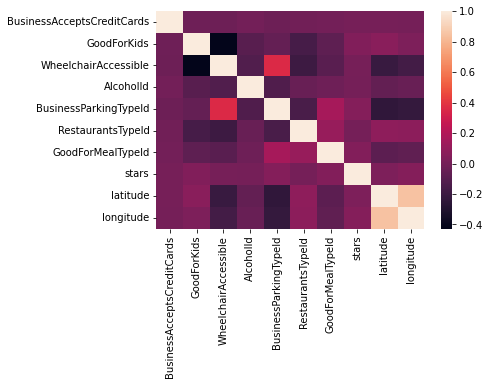

In [14]:
sns.heatmap(correlations)
plt.show()

In [15]:
def evaluateModel(model, X_train, y_train, X_test, y_test):
    # FIT THE MODEL
    model.fit(X_train, y_train)

    # EVALUATE the MODEL
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # PRINT the METRICS
    print("TRAINING SET")

    class_report_train = classification_report(y_train, train_preds)
    conf_matrix_train = confusion_matrix(y_train, train_preds)

    print(class_report_train)
    print(conf_matrix_train)

    print()

    # PRINT the METRICS
    print("Testing SET")

    class_report_test = classification_report(y_test, test_preds)
    conf_matrix_test = confusion_matrix(y_test, test_preds)

    print(class_report_test)
    print(conf_matrix_test)
    
# Can't build ROC curve on multicategorical data set    
#     # Creates the Roc Curve
#     y_pred_proba = model.predict_proba(X_test)[::,1]
#     fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
#     auc = roc_auc_score(y_test, y_pred_proba)

#     plt.figure(figsize=(10,6))
#     plt.plot(fpr,tpr,label="auc="+str(auc))
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title("ROC Curve Test Set")
#     plt.legend(loc=4)
#     plt.show()
    
    return(model)

In [16]:
 # get data
X = model_df[columns]
y = model_df[target]
y

,stars
0,5
1,3
2,4
3,3
4,4
...,...
13843,3
13844,4
13845,5
13846,4


In [17]:
# Use the Sklearn `train_test_split()` function to split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25, stratify=y)

print(len(X_train) / len(X))
print(len(X_test) / len(X))

0.7499456245921844
0.25005437540781555


In [18]:
# XGBoost Regression
xgb = XGBClassifier(random_state=42)
xgb = evaluateModel(xgb, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       665
           3       0.57      0.16      0.25      3326
           4       0.52      0.95      0.67      5081
           5       0.73      0.01      0.02      1272

    accuracy                           0.52     10344
   macro avg       0.46      0.28      0.23     10344
weighted avg       0.53      0.52      0.41     10344

[[   0   90  574    1]
 [   0  541 2783    2]
 [   0  241 4839    1]
 [   0   72 1189   11]]

Testing SET
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       222
           3       0.37      0.10      0.16      1109
           4       0.50      0.92      0.65      1694
           5       0.00      0.00      0.00       424

    accuracy                           0.49      3449
   macro avg       0.22      0.26      0.20      3449
weighted avg       0.36      0.49      0.37      3449

[[   0   38

In [19]:
# Scale pos weight formula = (row count - count of least populous class) / count of least populous class; value is 14.5 
# XGBoost Regression
xgb = XGBClassifier(random_state=42, scale_pos_weight=14)
xgb = evaluateModel(xgb, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       665
           3       0.57      0.16      0.25      3326
           4       0.52      0.95      0.67      5081
           5       0.73      0.01      0.02      1272

    accuracy                           0.52     10344
   macro avg       0.46      0.28      0.23     10344
weighted avg       0.53      0.52      0.41     10344

[[   0   90  574    1]
 [   0  541 2783    2]
 [   0  241 4839    1]
 [   0   72 1189   11]]

Testing SET
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       222
           3       0.37      0.10      0.16      1109
           4       0.50      0.92      0.65      1694
           5       0.00      0.00      0.00       424

    accuracy                           0.49      3449
   macro avg       0.22      0.26      0.20      3449
weighted avg       0.36      0.49      0.37      3449

[[   0   38

In [20]:
# Scale pos weight formula = (row count - count of least populous class) / count of least populous class; value is 14.5 
# XGBoost Regression
xgb = XGBClassifier(random_state=42, scale_pos_weight=15)
xgb = evaluateModel(xgb, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       665
           3       0.57      0.16      0.25      3326
           4       0.52      0.95      0.67      5081
           5       0.73      0.01      0.02      1272

    accuracy                           0.52     10344
   macro avg       0.46      0.28      0.23     10344
weighted avg       0.53      0.52      0.41     10344

[[   0   90  574    1]
 [   0  541 2783    2]
 [   0  241 4839    1]
 [   0   72 1189   11]]

Testing SET
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       222
           3       0.37      0.10      0.16      1109
           4       0.50      0.92      0.65      1694
           5       0.00      0.00      0.00       424

    accuracy                           0.49      3449
   macro avg       0.22      0.26      0.20      3449
weighted avg       0.36      0.49      0.37      3449

[[   0   38

In [21]:
y_probs = y.copy()
y_probs.head(20)

,stars
0,5
1,3
2,4
3,3
4,4
5,4
6,2
7,3
8,2
9,3


In [22]:
y_probs["probability_class_2"] = xgb.predict_proba(X)[:, 0]
y_probs["probability_class_3"] = xgb.predict_proba(X)[:, 1]
y_probs["probability_class_4"] = xgb.predict_proba(X)[:, 2]
y_probs["probability_class_5"] = xgb.predict_proba(X)[:, 3]
y_probs

,stars,probability_class_2,probability_class_3,probability_class_4,probability_class_5
0,5,0.037889,0.345739,0.486167,0.130205
1,3,0.044092,0.381071,0.497736,0.077102
2,4,0.094871,0.346275,0.385723,0.173131
3,3,0.033639,0.282405,0.546417,0.137539
4,4,0.034959,0.348602,0.470250,0.146188
...,...,...,...,...,...
13843,3,0.084255,0.335454,0.402966,0.177325
13844,4,0.088350,0.358044,0.427017,0.126590
13845,5,0.062672,0.185875,0.534954,0.216499
13846,4,0.082976,0.361976,0.476373,0.078674


In [23]:
# sum(2proba*2 + 3proba*3 + 4proba*4 + 5proba*5)
y_probs["rating"] = (y_probs["probability_class_2"]*2) + (y_probs["probability_class_3"]*3) + (y_probs["probability_class_4"]*4) + (y_probs["probability_class_5"]*5)
y_probs

,stars,probability_class_2,probability_class_3,probability_class_4,probability_class_5,rating
0,5,0.037889,0.345739,0.486167,0.130205,3.708689
1,3,0.044092,0.381071,0.497736,0.077102,3.607848
2,4,0.094871,0.346275,0.385723,0.173131,3.637113
3,3,0.033639,0.282405,0.546417,0.137539,3.787855
4,4,0.034959,0.348602,0.470250,0.146188,3.727667
...,...,...,...,...,...,...
13843,3,0.084255,0.335454,0.402966,0.177325,3.673361
13844,4,0.088350,0.358044,0.427017,0.126590,3.591847
13845,5,0.062672,0.185875,0.534954,0.216499,3.905281
13846,4,0.082976,0.361976,0.476373,0.078674,3.550745


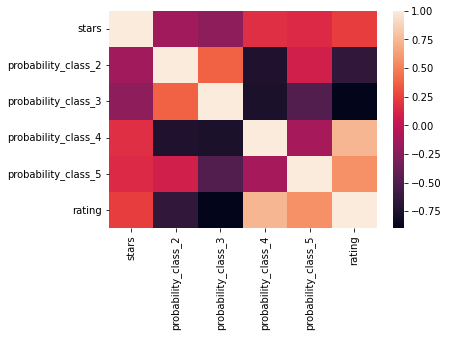

In [24]:
corrs = y_probs.corr()

sns.heatmap(corrs)
plt.show()

In [25]:
corrs

,stars,probability_class_2,probability_class_3,probability_class_4,probability_class_5,rating
stars,1.000000,-0.140571,-0.217758,0.169625,0.141380,0.235144
probability_class_2,-0.140571,1.000000,0.374137,-0.741056,0.085698,-0.652827
probability_class_3,-0.217758,0.374137,1.000000,-0.759870,-0.492803,-0.900143
probability_class_4,0.169625,-0.741056,-0.759870,1.000000,-0.116860,0.736746
probability_class_5,0.141380,0.085698,-0.492803,-0.116860,1.000000,0.566788
rating,0.235144,-0.652827,-0.900143,0.736746,0.566788,1.000000


In [26]:
(y_probs["probability_class_2"]*2) + (y_probs["probability_class_3"]*3) + (y_probs["probability_class_4"]*4) + (y_probs["probability_class_5"]*5)

0        3.708689
1        3.607848
2        3.637113
3        3.787855
4        3.727667
           ...   
13843    3.673361
13844    3.591847
13845    3.905281
13846    3.550745
13847    3.492553
Length: 13793, dtype: float32

In [27]:
# RandomForestClassifier Regression
rfc = RandomForestClassifier(random_state=42)
rfc = evaluateModel(rfc, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       0.99      0.97      0.98       665
           3       0.99      0.99      0.99      3326
           4       0.99      0.99      0.99      5081
           5       0.99      0.99      0.99      1272

    accuracy                           0.99     10344
   macro avg       0.99      0.98      0.99     10344
weighted avg       0.99      0.99      0.99     10344

[[ 643   11    9    2]
 [   4 3292   27    3]
 [   1   24 5053    3]
 [   1    6   10 1255]]

Testing SET
              precision    recall  f1-score   support

           2       0.12      0.07      0.09       222
           3       0.34      0.34      0.34      1109
           4       0.51      0.58      0.54      1694
           5       0.17      0.12      0.14       424

    accuracy                           0.41      3449
   macro avg       0.29      0.28      0.28      3449
weighted avg       0.39      0.41      0.40      3449

[[ 16  90  

In [28]:
# AdaBoostClassifier Regression
abc = AdaBoostClassifier(random_state=42)
abc = evaluateModel(abc, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       0.50      0.00      0.00       665
           3       0.45      0.09      0.16      3326
           4       0.50      0.95      0.66      5081
           5       0.67      0.00      0.00      1272

    accuracy                           0.50     10344
   macro avg       0.53      0.26      0.20     10344
weighted avg       0.51      0.50      0.37     10344

[[   1   82  582    0]
 [   0  313 3013    0]
 [   1  248 4831    1]
 [   0   48 1222    2]]

Testing SET
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       222
           3       0.39      0.09      0.14      1109
           4       0.50      0.94      0.65      1694
           5       0.00      0.00      0.00       424

    accuracy                           0.49      3449
   macro avg       0.22      0.26      0.20      3449
weighted avg       0.37      0.49      0.37      3449

[[   0   29

In [29]:
# ExtraTreesClassifier Regression
etc = ExtraTreesClassifier(random_state=42)
etc = evaluateModel(etc, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       0.96      1.00      0.98       665
           3       0.98      1.00      0.99      3326
           4       1.00      0.99      0.99      5081
           5       1.00      0.98      0.99      1272

    accuracy                           0.99     10344
   macro avg       0.99      0.99      0.99     10344
weighted avg       0.99      0.99      0.99     10344

[[ 662    2    1    0]
 [  13 3310    3    0]
 [   9   48 5024    0]
 [   3    9   13 1247]]

Testing SET
              precision    recall  f1-score   support

           2       0.13      0.11      0.12       222
           3       0.34      0.33      0.33      1109
           4       0.51      0.55      0.53      1694
           5       0.17      0.14      0.15       424

    accuracy                           0.40      3449
   macro avg       0.29      0.28      0.28      3449
weighted avg       0.39      0.40      0.39      3449

[[ 24  86  

In [30]:
# GradientBoostingClassifier Regression
gbc = GradientBoostingClassifier(random_state=42)
gbc = evaluateModel(gbc, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       1.00      0.03      0.06       665
           3       0.62      0.19      0.29      3326
           4       0.52      0.95      0.68      5081
           5       0.92      0.04      0.08      1272

    accuracy                           0.54     10344
   macro avg       0.76      0.30      0.28     10344
weighted avg       0.63      0.54      0.44     10344

[[  20   92  551    2]
 [   0  641 2683    2]
 [   0  241 4839    1]
 [   0   67 1151   54]]

Testing SET
              precision    recall  f1-score   support

           2       0.38      0.01      0.03       222
           3       0.40      0.13      0.20      1109
           4       0.50      0.90      0.64      1694
           5       0.19      0.01      0.01       424

    accuracy                           0.49      3449
   macro avg       0.37      0.26      0.22      3449
weighted avg       0.42      0.49      0.38      3449

[[   3   36

In [31]:
# LGBMClassifier Regression
lgb = LGBMClassifier(random_state=42)
lgb = evaluateModel(lgb, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       0.82      0.06      0.11       665
           3       0.60      0.40      0.48      3326
           4       0.58      0.90      0.70      5081
           5       0.74      0.08      0.14      1272

    accuracy                           0.58     10344
   macro avg       0.68      0.36      0.36     10344
weighted avg       0.62      0.58      0.52     10344

[[  40  193  423    9]
 [   5 1321 1987   13]
 [   3  485 4579   14]
 [   1  203  967  101]]

Testing SET
              precision    recall  f1-score   support

           2       0.29      0.01      0.02       222
           3       0.37      0.25      0.30      1109
           4       0.51      0.81      0.63      1694
           5       0.17      0.02      0.03       424

    accuracy                           0.48      3449
   macro avg       0.34      0.27      0.24      3449
weighted avg       0.41      0.48      0.41      3449

[[   2   77

## Model Selection

In [32]:
# Selected LightGBM because it had the best stats and seemed the least overfit by a small margin.

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(lgb, open(filename, 'wb'))

## Helper functions

In [33]:
# CONTENT OPTIONS:
# ByAppointmentOnly: BIT
# BusinessAcceptsCreditCards: BIT
# GoodForKids: BIT
# WheelchairAccessible: BIT
# BikeParking: BIT
# HasTV: BIT
# Caters: BIT
# HappyHour: BIT
# GoodForDancing: BIT
# OutdoorSeating: BIT
# CoatCheck: BIT
# DriveThru: BIT

def convert_bit(input_val):
    if input_val=='False':
        return 0
    elif input_val=='True': 
        return 1
    else: 
        pass
    
# convert_bit("butter")

In [34]:
# CONTENT OPTIONS:
# Alcohol: CATEGORY
# 	no: 1
# 	full_bar: 2
# 	none: 3
# 	beer_and_wine: 4
# NoiseLevel: CATEGORY
# 	no: 1
# 	average: 2
# 	loud: 3
# 	quiet: 4
# WiFi: CATEGORY
# 	no: 1
# 	free: 2
# 	paid: 3
# Smoking: CATEGORY
# 	no: 1
# 	outdoor: 2
# 	yes: 3
# BYOBCorkage: 
# 	no: 1
# 	yes_free: 2
# 	yes_corkage: 3
# BusinessParkingType: CATEGORY
# 	na: 1
# 	BusinessParkinglot: 4
# 	BusinessParkingstreet: 2
# 	BusinessParkinggarage: 1
# 	BusinessParkingvalet: 5
# 	BusinessParkingvalidated: 3
# MusicType: CATEGORY
# 	na: 0
# 	Musicdj: 1
# 	Musickaraoke: 2
# RestaurantsType: CATEGORY
# 	na: 0
# 	RestaurantsGoodForGroups: 2
# 	RestaurantsTakeOut: 4
# 	RestaurantsTableService: 5
# 	RestaurantsDelivery: 6
# 	RestaurantsReservations: 3
# GoodForMealType: CATEGORY
# 	na: 0
# 	GoodForMealdinner: 4
# 	GoodForMeallunch: 3
# 	GoodForMealbrunch: 6
# 	GoodForMealbreakfast: 5
# 	GoodForMealdessert: 1
# 	GoodForMeallatenight: 2
# DietaryRestrictionsType: CATEGORY 
# 	na: 0
# 	DietaryRestrictionsvegetarian: 7
# 	DietaryRestrictionsvegan: 3
# BestNightsType: CATEGORY
# 	na: 0
# 	BestNightssaturday: 6
# 	BestNightsfriday: 2

def convert_id(input_val, category):
    # Select data into dataframe
    sql_stmt = r"select id from " + category + "Type where description == '" + input_val + "';"

    input_val_df = pd.read_sql(sql_stmt, engine)
    return input_val_df["id"][0] if len(input_val_df)>0 else 0

In [45]:
def get_category(name):
    # Select data into dataframe
    type = f"select description from {name}"
    type_df = pd.read_sql(type, engine)

    return type_df["description"].to_json()

In [57]:
def get_value(type):

    if type == 'lat':
        num = random.uniform(31.5, 37.5)
    elif type == 'long':
        num = random.uniform(-109.5, -113.5)
    else:
        num = "Try again numbskull"
    
    return num

get_value("cheese")

'Try again numbskull'

## For web deployment

In [35]:
content = { "BusinessAcceptsCreditCards": "True",
            "GoodForKids": "True",
            "WheelchairAccessible": "True",
            "Alcohol": "full_bar",
            "BusinessParkingType": "BusinessParkinglot",
            "RestaurantsType": "na",
            "GoodForMealType": "na",
            "latitude": 1.684984,
            "longitude": 69.654968}
content

{'BusinessAcceptsCreditCards': 'True',
 'GoodForKids': 'True',
 'WheelchairAccessible': 'True',
 'Alcohol': 'full_bar',
 'BusinessParkingType': 'BusinessParkinglot',
 'RestaurantsType': 'na',
 'GoodForMealType': 'na',
 'latitude': 1.684984,
 'longitude': 69.654968}

In [36]:
# Parse content
BusinessAcceptsCreditCards = convert_bit(content["BusinessAcceptsCreditCards"])
GoodForKids = convert_bit(content["GoodForKids"])
WheelchairAccessible = convert_bit(content["WheelchairAccessible"])
BusinessParkingTypeId = convert_id(content["BusinessParkingType"], "BusinessParking")
RestaurantsTypeId = convert_id(content["RestaurantsType"], "Restaurants")
GoodForMealTypeId = convert_id(content["GoodForMealType"], "GoodForMeal")
AlcoholId = convert_id(content["Alcohol"], "Alcohol")
latitude = float(content["latitude"])
longitude = float(content["longitude"])

In [37]:
prediction_input = [[BusinessAcceptsCreditCards,
                    GoodForKids,
                    WheelchairAccessible,
                    AlcoholId,
                    BusinessParkingTypeId,
                    RestaurantsTypeId,
                    GoodForMealTypeId,
                    latitude, 
                    longitude]]

prediction_input

[[1, 1, 1, 2, 4, 0, 0, 1.684984, 69.654968]]

In [38]:
df = pd.DataFrame(prediction_input, columns=['BusinessAcceptsCreditCards',
                                            'GoodForKids',
                                            'WheelchairAccessible',
                                            'AlcoholId',
                                            'BusinessParkingTypeId',
                                            'RestaurantsTypeId',
                                            'GoodForMealTypeId',
                                            'latitude', 
                                            'longitude'])

df

,BusinessAcceptsCreditCards,GoodForKids,WheelchairAccessible,AlcoholId,BusinessParkingTypeId,RestaurantsTypeId,GoodForMealTypeId,latitude,longitude
0,1,1,1,2,4,0,0,1.684984,69.654968


In [39]:
filename = 'finalized_model.sav'
model_load = pickle.load(open(filename, 'rb'))

In [40]:
X = np.array(df.values)
preds = model_load.predict_proba(X)
preds_singular = model_load.predict(X)

In [41]:
result = preds_singular.item()
pct = round(preds[:,preds_singular-2].item()*100,2)

In [42]:
print(f"We're {pct}% sure your restaurant would get a {result}-star rating on Yelp!")

We're 62.14% sure your restaurant would get a 4-star rating on Yelp!
